# 2. Hands-on experiment 2: k-means Clustering by Semidefinite Programming

Clustering is an unsupervised machine learning problem in which we try to partition a given data set into $k$ subsets based on distance between data points or similarity among them. The goal is to find $k$ centers and to assign each data point to one of the centers such that the sum of the square distances between them are minimal [1]. This problem is known to be NP-hard. 

### Clustering problem
Given a set of $n$ points in a $d-$dimensional Euclidean space, denoted by
\begin{equation*}
S = \{ \mathbf{s}_i = (s_{i1}, \cdots, s_{id})^\top~\in \mathbb{R}^d ~~ i = 1, \cdots, n\}
\end{equation*}
find an assignment of the $n$ points into $k$ disjoint clusters $\mathcal{S} = (S_1, \cdots, S_k)$ whose centers are $\mathbf{c}_j(j = 1, \cdots, k)$ based on the total sum of squared Euclidean distances from each point $\mathbf{s}_i$ to its assigned cluster centroid $\mathbf{c}_i$, i.e.,
\begin{equation}
f(S,\mathcal{S}) = \sum_{j=1}^k\sum_{i=1}^{|S_j|}\|\mathbf{s}_i^{j} - \mathbf{c}_j \|^2,
\label{eq:kmeans}\tag{1}
\end{equation}
where $|S_j|$ is the number of points in $S_j$, and $\mathbf{s}_i^{j} $ is the $i^{th}$ point in $S_j$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh, svds, eigs
from math import sqrt
import scipy.io as sio
import random
import numpy.matlib
from helpers import *
import time
from scipy.sparse import isspmatrix
from Llyod_kmeans import *
# fix the seed
random.seed( 3 )

In [2]:
# Load data
Problem = sio.loadmat('data/clustering_data.mat')
C = np.double(Problem['C']) # euclidean distance matrix
N = np.int(Problem['N']) # number of data points
k = Problem['k'] # number of clusters
opt_val = Problem['opt_val'] # optimum value 
images = Problem['images'] # images for visualization after clustering
labels = Problem['labels'] # true labels
digits = Problem['digits']

C:\Users\Elia\AppData\Local\Temp/ipykernel_26348/2127974238.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  N = np.int(Problem['N']) # number of data points


### Problem 2.1 Conditional gradient method for clustering fashion-mnist Data
---
#### <span style="font-variant:small-caps;">(e) *(20 points)*</span>


 $\triangleright$ Complete the missing lines in the function definitions of `HCGM` and `PDHG`, which implements Homotopy CGM and Vu-Condat algorithms, respectively. Run both methods $2000$ iterations to solve the $k$-means clustering problem.

$\triangleright$ Plot the convergence results of both algorithms using `plot_comp` function.

$\triangleright$ What are the final objective values? Are they below the optimal value provided to you? If yes, explain the reason.

$\triangleright$ Using the function `value_kmeans`, compute and report the $k$-means value before and after running both algorithms. 

$\triangleright$ Run the function \texttt{kmeans} a few times and report the $k$-means value obtained by Llyod's algorithm. Compare it with the ones obtained by rounding the solution of convex methods `HCGM` and `PDHG`. Comment on the result.

(<span style="font-variant:small-caps;"> Hint: </span> Note that when $\mathcal{X}$ is as given in equation (2), $\kappa u u^\top \in \text{lmo}_{\mathcal{X}}(X)$, where $u$ is the eigenvector corresponding to the smallest eigenvalue of $X$.)

---

### Define operators
We provide 2 operators and their conjugates:
1. `A1`: Linear operator that takes the row sums
2. `At2`: Conjugate of operator A1
3. `A2`: Linear operator that takes the column sums 
4. `At2`: Conjugate of operator A2

In [3]:
A1 = lambda x: np.sum(x, axis = 1)
At1 = lambda y: np.transpose(np.matlib.repmat(y, N, 1))
A2 = lambda x: np.sum(x, axis = 0)
At2 = lambda y: (np.matlib.repmat(y, N, 1))

b = np.double(np.ones(N))

In [4]:
def plot_comp(it, f1,f2, obj):
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.loglog(it[0], f1[0], label='PDHG')#, 'go--', linewidth=2, markersize=12))
    plt.loglog(it[1], f1[1], label='HCGM')#, 'go--', linewidth=2, markersize=12))
    plt.xlabel('t (sec)',fontsize=15)
    plt.ylabel('$\|X1-1\|/1$',fontsize=15)
    plt.grid(True)
    

    plt.subplot(222)
    plt.loglog(it[0], f2[0], label='PDHG' )
    plt.loglog(it[1], f2[1], label='HCGM' )
    plt.xlabel('t (sec)',fontsize=15)
    plt.ylabel('dist$(X, \mathbb{R}^{n}_+)$',fontsize=15)
    plt.grid(True)
    plt.show()

    obj_res_PDHG = np.reshape(np.abs(obj[0] - opt_val)/opt_val, (len(obj[0]),))
    obj_res_HCGM = np.reshape(np.abs(obj[1] - opt_val)/opt_val, (len(obj[1]),))
    plt.figure(figsize=(12, 8))
    plt.loglog((it[0]), (obj_res_PDHG), label='PDHG')
    plt.loglog((it[1]), (obj_res_HCGM), label='HCGM')
    plt.xlabel('t (sec)',fontsize=15)
    plt.ylabel('$(f(X) - f^*)/f^*$',fontsize=15)
    plt.title('Relative objective residual',fontsize=15)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.show()

### Algorithm 1. Homotopy CGM

**Remark:** For simplicity, there is only one penalty parameter $\beta_k$ in the HCGM Algorithm. However, in practice, one can have different penalty parameters for different constraints. In our case, we advise you to ***multiply by 1000 the term $ (x_k - \text{proj}_{\mathcal{K}}(x_k))$** in Algorithm 1, in order to obtain a better practical convergence. This basically corresponds to having different penalty parameters for different constraints.


In [5]:
def HCGM(kappa=10, maxit=np.int(1e3), beta0=1):
    # Initialize
    X = np.zeros((N,N))
    AX1_b = 0.0
    
    feasibility1 = [] # norm(A1(X)-b1)/norm(b1)
    feasibility2 = [] # dist(X, \mathcal{K})
    objective    = [] # f(x)
    cur_iter    = []   
    t    = []         # for time tracking
    
    iter_track = np.unique(np.ceil(np.power(2, np.linspace(0,20,50))))
    
    start = time.time()
    
    for iteration in range(1, maxit+1):
        
        # Update Step Size
        gamma = 2 / (iteration + 1)
        
        # Update beta
        beta_ = beta0/sqrt(iteration + 1)
        
        # Write down the vk to use in the lmo (eigenvalue routine)
        vk = beta_*C + At1(A1(X) - b) + At2(A2(X) - b) + 1000*(X - np.maximum(np.zeros(X.shape), X))
        vk = 0.5*(vk + vk.T)
        
        # Linear minimization oracle
        q, u = eigsh(vk, k=1, tol=1e-16, which='SA')

        if np.all( q > 0):
            u = np.zeros([u.shape[0],u.shape[0]])
        else:
            u = sqrt(kappa)*u
        
        X_bar = np.outer(u,u)
        
        # Obtain A*Xbar - b
        AX_bar_b = A1(X_bar)-b
        
        # Update A*X - b
        AX1_b = (1.0-gamma)*AX1_b + gamma*(AX_bar_b)
        
        # Update X
        X = (1 - gamma)*X + gamma*X_bar
                
        if any(iteration == iter_track) or iteration==maxit:
            feasibility1.append(np.linalg.norm(AX1_b)/N)
            feasibility2.append(np.linalg.norm(np.minimum(X,0), ord='fro'))
            objective.append(np.sum(C.flatten()*X.flatten()))
            cur_iter.append(iteration)
            t.append(time.time()-start)
            print('{:03d} | {:.4e}| {:.4e}| {:.4e}|'.format(iteration, feasibility1[-1], feasibility2[-1],objective[-1]))
            
    return X, feasibility1, feasibility2, objective, cur_iter, t

C:\Users\Elia\AppData\Local\Temp/ipykernel_26348/602651133.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def HCGM(kappa=10, maxit=np.int(1e3), beta0=1):


#### Run HCGM

In [6]:
tstart = time.time()
X_HCGM, f1_HCGM, f2_HCGM, obj_HCGM, iter_HCGM, time_HCGM = HCGM(10, np.int(5000), 1)
elapsed = time.time() - tstart
print('HCGM took {} sec'.format(elapsed))

C:\Users\Elia\AppData\Local\Temp/ipykernel_26348/4132485510.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_HCGM, f1_HCGM, f2_HCGM, obj_HCGM, iter_HCGM, time_HCGM = HCGM(10, np.int(5000), 1)


001 | 2.8157e-01| 0.0000e+00| 1.5028e+04|
002 | 7.2775e-02| 2.8124e+00| 4.0633e+03|
003 | 3.8797e-02| 2.8820e+00| 1.7951e+03|
004 | 6.0178e-02| 1.6950e+00| 2.1542e+03|
005 | 4.4115e-02| 1.8916e+00| 2.3621e+03|
006 | 3.9321e-02| 1.3341e+00| 2.1423e+03|
008 | 3.1495e-02| 1.3564e+00| 1.9023e+03|
010 | 2.7986e-02| 1.0876e+00| 1.7042e+03|
013 | 9.1450e-03| 1.1454e+00| 8.7334e+02|
017 | 9.7534e-03| 8.7930e-01| 8.0521e+02|
023 | 1.0672e-02| 6.6643e-01| 8.7141e+02|
030 | 7.5734e-03| 4.7975e-01| 7.2881e+02|
040 | 7.0140e-03| 3.3010e-01| 6.7838e+02|
053 | 4.0746e-03| 3.2327e-01| 5.9426e+02|
070 | 3.7772e-03| 2.4258e-01| 5.2278e+02|
093 | 2.2155e-03| 2.3670e-01| 4.3083e+02|
123 | 2.8115e-03| 1.6968e-01| 4.9678e+02|
163 | 1.6708e-03| 1.3773e-01| 4.9555e+02|
217 | 1.8521e-03| 9.5496e-02| 4.6015e+02|
287 | 1.2603e-03| 6.4898e-02| 4.8715e+02|
381 | 1.0575e-03| 5.8019e-02| 4.1287e+02|
505 | 7.8875e-04| 4.8663e-02| 3.7704e+02|
670 | 8.2401e-04| 3.8831e-02| 3.1086e+02|
889 | 6.0224e-04| 3.4744e-02| 2.52

### Algorithm 2. Vu-Condat

**Remarks:** 

- A similar observation applies tor the Vu-Condat algorithm: it is possible to use different dual step sizes $\{ \sigma_1 , \sigma_2, \ldots \}$. In our case, we advise you to **multiply the step-size for $y_3$ by $10^4$** to obtain a better practical convergence. (You can directly use the tuned stepsizes for PDHG.)

- In this part, you will need the projection operator of the nuclear norm ball. So, you can use what you implemented in part1 of the homework as the projection operator in the algorithm. 

In [7]:
def PDHG(kappa=10, maxit=np.int(1e3), beta0=1):
    # Initialize
    X = np.zeros((N,N))
    Xprev = X
    AX1_b = 0.0
    
    y1 = A1(X)
    y2 = A2(X)
    y3 = X
    
    normC = np.linalg.norm(C,'fro')
    
    
    feasibility1 = [] # norm(A1(X)-b1)/norm(b1)
    feasibility2 = [] # dist(X, \mathcal{K})
    objective    = [] # f(x)
    cur_iter    = [] 
    t    = [] 
    
    L = 1e2      
    
    iter_track = np.unique(np.ceil(np.power(2, np.linspace(0,20,50))))
    
    start = time.time()
    # Primal and dual step sizes
    tau = 1/L # primal stepsize
    sigma = 1/(L**2*tau) # dual step size
    sigma2 = sigma*1e4   # different dual step size to use for the update of y3 for better practical performance.

    
    for iteration in range(1, maxit+1):
        
        # Primal variable update
        Xprev = X # store the previous iterate for reflection
        X = projSDP(Xprev - tau*(C + At1(y1) + At2(y2) + y3), kappa)
        
        # Dual variable updates
        Xhat = 2*X - Xprev # the point at which the dual gradient is calculated
        y1 = y1 + sigma*(A1(Xhat) - b)
        y2 = y2 + sigma*(A2(Xhat) - b)
        a = y3/sigma2 + Xhat
        y3 = y3 + sigma2*(Xhat - np.maximum(np.zeros(a.shape), a))
                
        # Update A*X - b
        AX1_b = A1(X)-b
        
        if any(iteration == iter_track) or iteration==maxit:
            feasibility1.append(np.linalg.norm(AX1_b)/N)
            feasibility2.append(np.linalg.norm(np.minimum(X,0), ord='fro'))
            objective.append(np.sum(C.flatten()*X.flatten()))
            cur_iter.append(iteration)
            t.append(time.time()-start)
            print('{:03d} | {:.4e}| {:.4e}| {:.4e}|'.format(iteration, feasibility1[-1], feasibility2[-1],objective[-1]))
            
    return X, feasibility1, feasibility2, objective, cur_iter, t

C:\Users\Elia\AppData\Local\Temp/ipykernel_26348/3230308970.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def PDHG(kappa=10, maxit=np.int(1e3), beta0=1):


#### Run Vu-Condat

In [8]:
tstart = time.time()
X_PDHG, f1_PDHG, f2_PDHG, obj_PDHG, iter_PDHG, time_PDHG = PDHG(10, np.int(1000), 1)
elapsed = time.time() - tstart
print('PDHG took {} sec'.format(elapsed))

C:\Users\Elia\AppData\Local\Temp/ipykernel_26348/2115167797.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_PDHG, f1_PDHG, f2_PDHG, obj_PDHG, iter_PDHG, time_PDHG = PDHG(10, np.int(1000), 1)


001 | 3.1586e-02| 1.2231e+00| -1.8503e+03|
002 | 3.1590e-02| 1.2607e+00| -1.8815e+03|
003 | 3.1583e-02| 1.2534e+00| -1.8806e+03|
004 | 3.1548e-02| 1.2014e+00| -1.8580e+03|
005 | 3.1492e-02| 1.1321e+00| -1.8194e+03|
006 | 3.1439e-02| 1.0802e+00| -1.7763e+03|
008 | 3.1428e-02| 1.0664e+00| -1.7127e+03|
010 | 3.1504e-02| 1.0696e+00| -1.6984e+03|
013 | 3.1555e-02| 1.0467e+00| -1.7131e+03|
017 | 7.3903e-03| 3.5223e-04| 5.4068e+01|
023 | 7.8687e-03| 1.1596e-02| 2.7390e+01|
030 | 6.4853e-03| 1.1006e-02| 2.8338e+01|
040 | 4.0236e-03| 9.5649e-03| 4.4584e+01|
053 | 3.0036e-03| 8.9718e-03| 5.6097e+01|
070 | 2.5701e-03| 7.6986e-03| 5.1988e+01|
093 | 1.6996e-03| 5.6568e-03| 5.9456e+01|
123 | 1.1468e-03| 3.8540e-03| 5.6114e+01|
163 | 5.0237e-04| 2.0250e-03| 5.6444e+01|
217 | 4.8175e-04| 1.9808e-03| 5.6829e+01|
287 | 2.2287e-04| 1.1415e-03| 5.6675e+01|
381 | 1.6155e-04| 9.4620e-04| 5.6739e+01|
505 | 1.2742e-04| 8.3259e-04| 5.6786e+01|
670 | 2.9261e-05| 2.1072e-04| 5.6994e+01|
889 | 1.8087e-06| 2.3632e

### Visualize the results

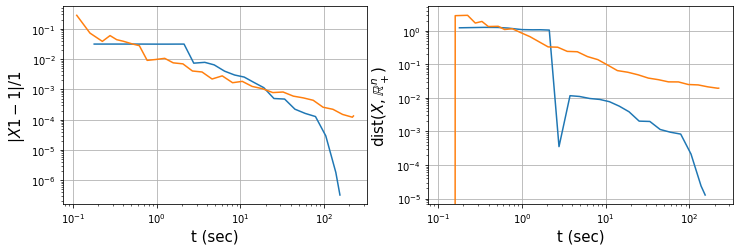

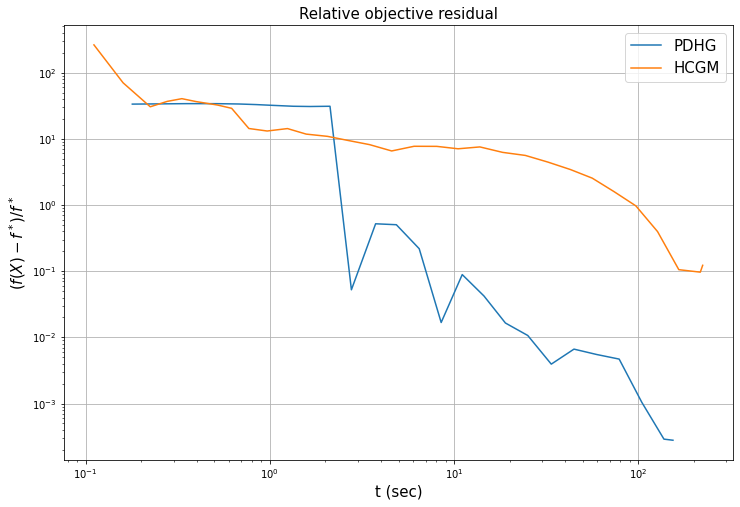

In [9]:
iters = (iter_PDHG, iter_HCGM)
times = (time_PDHG, time_HCGM)
feas1 = (f1_PDHG, f1_HCGM)
feas2 = (f2_PDHG, f2_HCGM)
obj   = (obj_PDHG, obj_HCGM)
plot_comp(times, feas1,feas2, obj)

In [10]:
print(obj_PDHG[len(obj_PDHG)-1])
print(obj_HCGM[len(obj_HCGM)-1])

57.03747459321611
50.057234846485294


### Rounding: Get the assignments from the result of the SDP
Getting the assignments requires going back to the $10$ dimensional space discussed before, and using the coordinates multiplied with the obtained matrix to construct a "denoised" version of the data points. This allows then to find the clusters from these $10$ dimensional data. See [3] for more details. Our implementation is the python reimplementation of their matlab code which can be found on [github](https://github.com/solevillar/kmeans_sdp).

In [11]:
center_HCGM, assign_HCGM = sdp_rounding(X_HCGM,10, digits)
center_PDHG, assign_PDHG = sdp_rounding(X_PDHG,10, digits)

### k-means value: HCGM & Vu-Condat

In [12]:
k_means_before = value_kmeans(digits, labels-1) # k_means value with true labels
k_means_after_HCGM  = value_kmeans(digits, assign_HCGM) # k_means value with assigned lables
k_means_after_PDHG  = value_kmeans(digits, assign_PDHG) # k_means value with assigned lables


print('k-means value initial: {:.4f}'.format(k_means_before))
print('k-means value for HCGM: {:.4f}'.format(k_means_after_HCGM))
print('k-means value for Vu-Condat: {:.4f}'.format(k_means_after_PDHG))

k-means value initial: 150.9680
k-means value for HCGM: 28.7269
k-means value for Vu-Condat: 28.7269


###  k-means value: Lloyd's algorithm

Run the Lloyd's algorithm directly on the input digits. 

In [13]:
for i in range(10):
    centers_Lloyd, classifications_Lloyd, k_means_Lloyd = kmeans(digits.T, 10)#k_means value with Lloyds k-means algorithm

    print('Run {:}: k-means value for Lloyd''s algorithm: {:.4f}'.format(i+1,k_means_Lloyd))

Run 1: k-means value for Lloyds algorithm: 112.2392
Run 2: k-means value for Lloyds algorithm: 301.6060
Run 3: k-means value for Lloyds algorithm: 235.2676
Run 4: k-means value for Lloyds algorithm: 227.8964
Run 5: k-means value for Lloyds algorithm: 92.3469
Run 6: k-means value for Lloyds algorithm: 102.5555
Run 7: k-means value for Lloyds algorithm: 236.0959
Run 8: k-means value for Lloyds algorithm: 191.2009
Run 9: k-means value for Lloyds algorithm: 262.4989
Run 10: k-means value for Lloyds algorithm: 92.5018


# OPTIONAL: Additional results for clustering fMNIST Data

### Misclassification rates: HCGM & Vu-Condat

In [14]:
print('Misclassification rate for HCGM: {:.4f}'.format(misclassification_rate(assign_HCGM, labels)))
print('Misclassification rate for Vu-Condat: {:.4f}'.format(misclassification_rate(assign_PDHG, labels)))

Misclassification rate for HCGM: 0.1250
Misclassification rate for Vu-Condat: 0.1250


### Visualize samples and predicted labels

In [15]:
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [16]:
def vis_samples(assignment, images, labels):
    assignment=assignment.astype(int)
    classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
    labels = labels-1
    rand_samp = np.random.randint(0,1000,25)
    plt.figure(figsize=(7,7))
    for i,samp in enumerate(rand_samp):
        plt.subplot(5,5,i+1)
        plt.imshow(1-np.reshape(images[samp],[28,28]), cmap=plt.cm.gray)
        plt.title('Pred. {0}\n Orig. {1}'.format(classes[assignment[samp].item()],classes[labels[samp].item()]))
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"samples{rand_samp[0]}.png")
    plt.show()

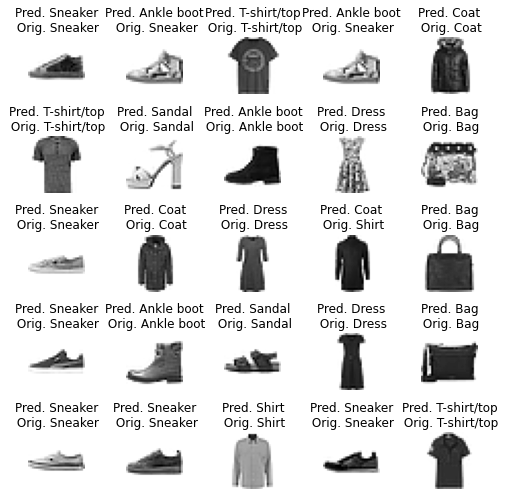

In [17]:
vis_samples(assign_HCGM, images,labels)

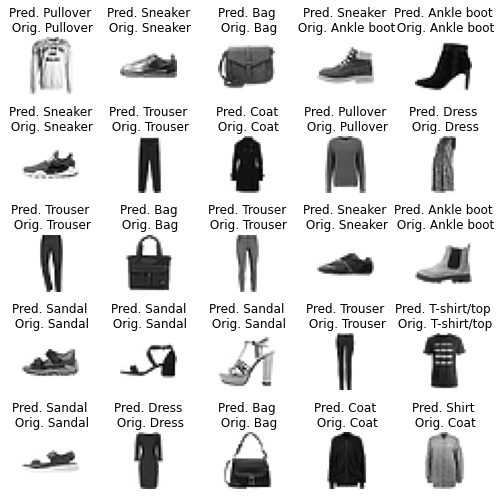

In [18]:
vis_samples(assign_PDHG, images,labels)